*   **Name** : GHOUL
*   **First name** : Branis
*   **Student number** : 28612738
*   **Master** : ISI

#Rendering of the advanced machine learning practical work 1 



# Import libraries  

In [58]:
# Import all the tools we need 

# Regular EDA and ploting libraries 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from tqdm import tqdm

%matplotlib inline 
#Cause we want our plots to appear in the notebook

# Model evaluation 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# We deactivate the warnings
import warnings
warnings.filterwarnings('ignore') 

# Generate and view a dataset

In [59]:
def generate_data_3classes(n1,n2,n3, display=True):
    X1 = np.random.randn(n1,2)*0.15 - np.array([0.2 , 0.2])
    X2 = np.random.randn(n2,2)*0.25 + np.array([0.1 , 0.5])
    X3 = np.random.randn(n3,2)*0.15 + np.array([0.6 , 0.2])
    X = np.concatenate((X1,X2,X3), axis=0)
    Y = np.concatenate([np.ones(n1), np.ones(n2)*2, np.ones(n3)*3])-1

    if display:
        plt.plot(X1[:,0], X1[:,1], '.r')
        plt.plot(X2[:,0], X2[:,1], '.g')
        plt.plot(X3[:,0], X3[:,1], '.b')
        plt.show()

    return X,Y

# Converts a class vector (integers) to binary class matrix (copy from keras)
def to_categorical(y, num_classes=None, dtype="float32"):
    y = np.array(y, dtype="int")
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])
    y = y.ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

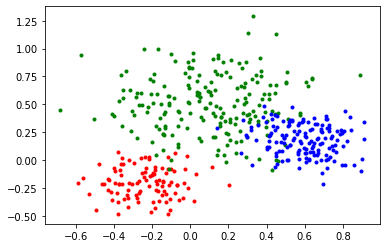

((450, 2), (450,))

In [60]:
X_train, Y_train = generate_data_3classes(100, 200, 150)
X_train.shape, Y_train.shape

In [61]:
Y_cat = to_categorical(Y_train)
Y_cat.shape, Y_cat

((450, 3), array([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        ...,
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], dtype=float32))

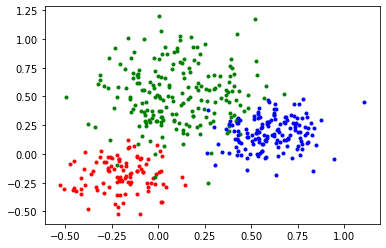

In [62]:
X_train, Y_train = generate_data_3classes(100, 200, 150)
Y_cat = to_categorical(Y_train)

K=Y_cat.shape[1] # nombre de classes
(num_examples, D) = X_train.shape # nombre d'exemples et dimension des exemples

In [63]:
# Fonction sigmoide
def sigmo(v):
	return 1/(1 + np.exp(-v))

# Derivative sigmoid function
def sigmop(v):
	return v * (1 - v)

In [64]:
# Random initialization of weights
W = 1 * np.random.normal(size=(D,K))
b = np.zeros((1,K))

# Learning parameters
step_size = 1e-1
num_iter = 20000

# Learning the network 

In this part we will create a single layer neural network model that can classify many different objects (n classes). We will use two different cost functions: mean square error and log loss. The latter are optimized with the gradient slope algorithm. Then we will evaluate the performance of our model with the two different cost functions.

In [68]:
from abc import ABC, abstractmethod

class CostFunction(ABC):
  def __init__(self, X, y_t, y):
    self.X = X
    self.y_t = y_t
    self.y = y
    self.err = y_t - y

  @abstractmethod
  def loss(self):
    pass
  
  @abstractmethod
  def lossp(self):
    pass


class LogLoss(CostFunction):
  def __init__(self, X, y_t, y):
    super().__init__(X, y_t, y)
  
  def loss(self):
    epsilon = 1e-15
    return 1 / len(self.y) * np.sum(-self.y * np.log(y_t + epsilon) - (1 - self.y) * np.log(1 - y_t + epsilon))
  
  def lossp(self):
    dW = 1/len(y) * np.dot(X.T, self.err)
    db = 1/len(y) * np.sum(self.err)
    return (dW, db)


class Mse(CostFunction):
  def __init__(self, X, y_t, y):
    super().__init__(X, y_t, y)
  
  def loss(self):
    return 1/len(y) * np.sum(self.err**2)
  
  def lossp(self):
    dW = 2 * np.dot( X.T, self.err*sigmop(y_t))
    db = 2 * np.sum(self.err*sigmop(y_t), axis=0)


class SingleLayerNeuralNetwork:
  """single layer neural network using gradient descent for n-class classification.
  Parameters
  ----------
  X             : numpy.ndarray
                  Train Dataset
  y             : numpy.ndarray
                  Labels of train dataset

  Attributes
  ----------
  X             : numpy.ndarray
                  Train Dataset
  y             : numpy.ndarray
                  Labels of train dataset
  nb_neurons    : int 
                number of neurons in the single layer neural network  
  W, b          : weights/ after fitting the model
  """

  def __init__(self, X, y, cost_function):
    self.X = X
    self.y = y

    assert len(np.unique(y)) > 1
    if np.unique(y)>2:
      self.nb_neurons = len(np.unique(y))
    else:
      self.nb_neurons = 1

    self.W = np.random.normal(loc=0.0, scale=1.0, size=(X.shape[1],  self.nb_neurons))
    self.b = np.random.normal(loc=0.0, scale=1.0, size=(self.nb_neurons)) 
    self.cost_function = cost_function

  def model(self):
    v = self.X.dot(self.W) + self.b
    y_t = sigmo(v)
    return (y_t, v)

  def update_weights(W, b, dW, db, eps=1e-3):
    self.W = self.W - eps*dW
    self.b = self.b - eps*db
    return (self.W, self.b)

  def predict(X):
    y_t, _ = self.model()
    return np.argmax(y_t, axis=1) if len(np.unique(y_t)) else y_t >= 0.5


In [ ]:
# Help functions 
def plot_decision_boundary(X, y, W, b, ax):
  """
  Plots the decision boundary created by a model predicting on X.
  This function has been adapted from two phenomenal resources:
   1. CS231n - https://cs231n.github.io/neural-networks-case-study/
   2. Made with ML basics - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb
  """
  # Define the axis boundaries of the plot and create a meshgrid
  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                       np.linspace(y_min, y_max, 100))
  
  # Create X values (we're going to predict on all of these)
  x_in = np.c_[xx.ravel(), yy.ravel()] # stack 2D arrays together: https://numpy.org/devdocs/reference/generated/numpy.c_.html
  
  # Make predictions using the trained model
  y_pred = predict(x_in, W, b).reshape(xx.shape)
  
  # Plot decision boundary
  ax.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
  ax.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
  # ax.xlim(xx.min(), xx.max())
  # ax.ylim(yy.min(), yy.max())

In [69]:
# Learning the network
X = X_train
Y = Y_train

snn = SingleLayerNeuralNetwork()
# dictionary containing future accuracy and log_loss
training_history = {'log_loss': [],
                    'accuracy': []}

for i in range(num_iter):
  # ==== propagation ==== #

  # State of the neurons
  y_t, _ = model(X_train, W, b)
  # log loss error
  Loss = log_loss(y_t, Y_cat)
  # Save accuracy score and log loss erroe for each iteration in a dictionary
  training_history['log_loss'].append(Loss)
  y_pred = predict(X, W, b)
  training_history['accuracy'].append(accuracy_score(Y.flatten(), y_pred.flatten()))

  if i % 1000 == 0:   
    print('iteration {}: loss {}'.format(i, Loss))
      
  # ==== retro-propagation ==== #

  dL_W, dL_b = gradients_log_loss(y_t, X, Y_cat)
  W, b =  update_weights(W, b, dL_W, dL_b, eps=step_size)        
  


iteration 0: loss 2.1385324583643905
iteration 1000: loss 0.7042763437165381
iteration 2000: loss 0.5831844511766392
iteration 3000: loss 0.5322930550387086
iteration 4000: loss 0.5033393924803703
iteration 5000: loss 0.4843451192928104
iteration 6000: loss 0.47080137901337205
iteration 7000: loss 0.46060068581425684
iteration 8000: loss 0.45261470593267616
iteration 9000: loss 0.446179866468433
iteration 10000: loss 0.4408780361728779
iteration 11000: loss 0.4364314231990309
iteration 12000: loss 0.432647581428659
iteration 13000: loss 0.42938858784366635
iteration 14000: loss 0.42655278373408234
iteration 15000: loss 0.42406345386269095
iteration 16000: loss 0.4218615337549352
iteration 17000: loss 0.41990075654060827
iteration 18000: loss 0.41814433154279057
iteration 19000: loss 0.41656261510421777


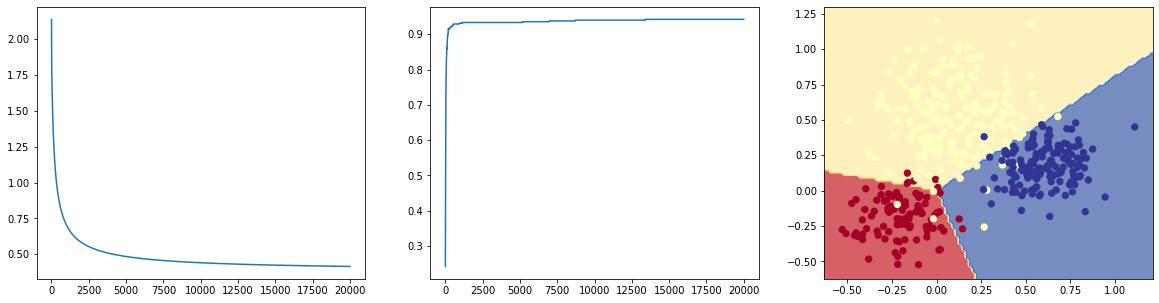

In [70]:
# Plot courbe d'apprentissage
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].plot(training_history['log_loss'], label='train log_loss')
axes[1].plot(training_history['accuracy'], label='train accuracy')
plot_decision_boundary(X, Y, W, b, axes[2])

iteration 0: loss -424.10194911847253
iteration 1: loss -427.14863129782475
iteration 2: loss -431.0811790978156
iteration 3: loss -436.1989852291788
iteration 4: loss -442.9219217198664
iteration 5: loss -451.81910834860753
iteration 6: loss -463.58340702677526
iteration 7: loss -478.8039349386802
iteration 8: loss -497.2665175172576
iteration 9: loss -516.8969326092086


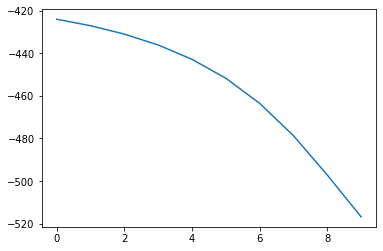

In [34]:
# Learning the network
X = X_train
Y = Y_train


# List of quadratic errors
se = []
for i in range(num_iter):
    # ==== propagation ==== #

    # State of the neurons
    v = X.dot(W)
    # Transition function
    Y_t = sigmo(v)
    # Loss function (quadratic error)
    eps = (Y_t - to_categorical(Y))
    loss = -np.sum(eps**2)
    # Save errors for each iteration in a list 
    se.append(loss)

    if i % 1 == 0:   
        print('iteration {}: loss {}'.format(i, loss))
        

    # ==== retro-propagation ==== #

    dL_W = 2 * np.dot(X.T, (eps * sigmop(v)))
    dL_b = 2 * np.sum(eps * sigmop(v))        

    W = W - step_size * dL_W
    b = b - step_size * dL_b
    

# Visualize the squared error for each iteration 
plt.plot(se)
plt.show()


In [12]:
Y_t.shape, to_categorical(Y).shape

((450, 3), (450, 3))

In [ ]:
# calcul de la précision
Y_pred = np.max(v, axis=1)
class_pred = np.argmax(v, axis=1)
print('Training accuracy: {:.2}'.format(np.mean(class_pred == Y_train)))

# Go further

Pour aller plus loin : 
- code d'évaluation des performances (et de visualisation)
- création d'un jeu de test indépendant (performance en généralisation)
- ajouter une couche cachée (observer les gains en performance et les frontières de décision)


In [79]:
class MLP:
  """MLPs using gradient descent for n-class classification.
  Parameters
  ----------
  X             : numpy.ndarray
                  Train Dataset
  y             : numpy.ndarray
                  Labels of train dataset
  hidden_layers : list
                  hidden_layers

  Attributes
  ----------
  X             : numpy.ndarray
                  Train Dataset
  y             : numpy.ndarray
                  Labels of train dataset
  all_layers    : list
                 A list containing the number of 
                 neurons of all layers of the MLP model
  weights       : weights/ after fitting the model

  """

  def init_weights(self, all_layers):
    np.random.seed(1)
    weights = {}

    for layer in range(1, len(all_layers)):
      weights['W' + str(layer)] = np.random.randn(all_layers[layer], all_layers[layer - 1])
      weights['b' + str(layer)] = np.random.randn(all_layers[layer], 1)

    return weights


  def __init__(self, X, y, hidden_layers):
    self.X = X
    self.y = y
    # self.all_layers = [X.shape[1]] + hidden_layers + [len(np.unique(y))]
    self.all_layers = [X.shape[1]] + hidden_layers + [1]
    self.weights = self.init_weights(self.all_layers)

  def forward_propagation(self):
    transition = {'A0': self.X}
    network_size = len(self.all_layers)

    for layer in range(1, network_size + 1):
      Z = self.weights['W' + str(layer)].dot(transition['A' + str(layer - 1)]) + self.weights['b' + str(layer)]
      transition['A' + str(layer)] = 1 / (1 + np.exp(-Z))

    return transition
  
  def back_propagation(self, transition):

    m = self.y.shape[1]
    network_size = len(self.all_layers)

    dZ = transition['A' + str(network_size)] - y
    gradients = {}

    for layer in reversed(range(1, network_size + 1)):
      gradients['dW' + str(layer)] = 1/m * np.dot(dZ, transition['A' + str(layer - 1)].T)
      gradients['db' + str(layer)] = 1/m * np.sum(dZ, axis=1, keepdims=True)
      if layer > 1:
        dZ = np.dot(self.weights['W' + str(layer)].T, dZ) * transition['A' + str(layer - 1)] * (1 - transition['A' + str(layer - 1)])

    return gradients
  
  def update(self, gradients, learning_rate=1e-1):
    network_size = len(self.all_layers)

    for c in range(1, network_size + 1):
        self.weights['W' + str(c)] = self.weights['W' + str(c)] - learning_rate * gradients['dW' + str(c)]
        self.weights['b' + str(c)] = self.weights['b' + str(c)] - learning_rate * gradients['db' + str(c)]

  def predict(self, X):
    activations = self.forward_propagation()
    network_size = len(self.all_layers)
    Af = activations['A' + str(network_size)]
    return Af >= 0.5


  def fit(self, learning_rate=1e-3, n_iter=100):
    """
    parameters :
    ------------
    learning_rate : float
                  The learning step of the gradient decent
    n_iter        : int
                  The number of learning iterations of the MLP model 
    """
    # dictionary containing future accuracy and log_loss
    training_history = {'training_accuracy' : [],
                        'training_log_loss'  : []}
    network_size = len(self.all_layers)

    # gradient descent
    for i in tqdm(range(n_iter)):

        transision = self.forward_propagation()
        gradients = self.back_propagation(y, transision)
        self.update(gradients, learning_rate)
        Af = transision['A' + str(network_size)]

        # calcul du log_loss et de l'accuracy
        training_history['training_accuracy'] = log_loss(y.flatten(), Af.flatten())
        y_pred = self.predict(X)
        training_history['training_log_loss'] = accuracy_score(y.flatten(), y_pred.flatten())

    # Plot courbe d'apprentissage
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(training_history['training_log_loss'], label='train loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(training_history['training_accuracy'], label='train acc')
    plt.legend()
    plt.show()

    return training_history  

# Dataset

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_circles
from sklearn.metrics import accuracy_score, log_loss
from tqdm import tqdm
from sklearn.metrics import accuracy_score, log_loss


In [81]:
X, y = make_circles(n_samples=100, noise=0.1, factor=0.3, random_state=0)
# X = X.T
# y = y.reshape((1, y.shape[0]))
y = y.reshape((-1, 1))
print('dimensions de X:', X.shape)
print('dimensions de y:', y.shape)

# plt.scatter(X[0, :], X[1, :], c=y, cmap='summer')
# plt.show()

dimensions de X: (100, 2)
dimensions de y: (100, 1)


In [82]:
mlp = MLP(X, y, hidden_layers=[16, 16, 16])
for k, v in mlp.weights.items():
  print(v.shape) 


(16, 2)
(16, 1)
(16, 16)
(16, 1)
(16, 16)
(16, 1)
(1, 16)
(1, 1)


In [83]:
training_history = mlp.fit(learning_rate=1e-3, n_iter=100)

  0%|          | 0/100 [00:00<?, ?it/s]


ValueError: ignored